In [18]:
#Automatic Extraction of Fit Data From a Trained CNN
#Created By Dominick Sinopoli Winter 2021
#windows only due to \ vs / on mac for file logic
import warnings
warnings.filterwarnings("ignore")
import TBU_Functions as tbu
import h0_function_single_pixel as h0_fun
import f0_function as f0_fun
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pickle
import os
import glob
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
image_path = r'01_/visit2/t7/*.png'
cor_doc = r'01_visit2_t7.csv'
corver = 3
model_path = r'CNN_model.h5'
frame_rate = 5  # 5 frames per second in this trial

In [4]:
# Find the first image with at least 3 instances of TBU.

# This is the most computationally intensive step by far. To speed it along, there is a modification made in TBU_Functions.py. To undo it, find the line with the comment "CHANGE BACK TO ZERO" and overwrite the value in that line with 0.

ROI_centers, first_file, cropped_image = tbu.get_first_tbu(
    image_path, model_path, cor_doc, frame_rate, num_tbu=3, thresh=.999, v=corver)

2022-08-26 15:41:59.497019: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
boxes = tbu.consolidate_ROI_clusters(ROI_centers)

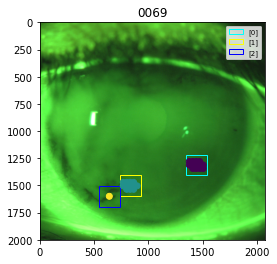

In [6]:
# show cropped image with boxes
fig,ax = plt.subplots(1)
ax.imshow(cropped_image)
colors = ['aqua','yellow','blue','brown','red','fuchsia','green','grey','indigo','khaki','lavender','lightblue','lime','maroon','navy','orange','orchid','pink','plum','purple','azure','gold']
max_val = int(len(boxes))
leg = np.zeros((max_val,1),dtype=int)
for i in range(max_val):
    x = boxes[i][0]
    y = boxes[i][1]
    rect = patches.Rectangle((x,y),192,192,facecolor='none',ec=colors[i])
    ax.add_patch(rect)
    leg[i,0] = i
plt.scatter(x=ROI_centers[:,0], y=ROI_centers[:,1], c=ROI_centers[:,2])
plt.legend(leg,fontsize=7)

plt.title(first_file.split(os.sep)[-1].split('.')[0].split('_')[-1]);

In [7]:
# For each box, get the min pixel locations for each image
locations = []
for i in range(len(boxes)):
    loc = tbu.get_all_min_locations(image_path, cor_doc, [boxes[i]], v=corver)
    locations.append(loc)

In [8]:
# Skipping first 3 seconds, find the median (over time) of the min point locations for each box.
median_mins = np.zeros((len(boxes),2),dtype=int)
for j in range(len(boxes)):
    median_mins[j,0] = int(np.median(locations[j][:,0]))
    median_mins[j,1] = int(np.median(locations[j][:,1]))

In [9]:
# Extract the fluorescent intensity at the median min locations over the entire trial.
intensity = tbu.get_intensity(image_path, cor_doc, boxes, median_mins, sigma=5, v=corver)

In [10]:
# Get the vector of time elapsed since the last blink before the trial.
last_blink = tbu.get_last_blink(image_path)
time = tbu.get_time_vector(image_path, frame_rate, last_blink)

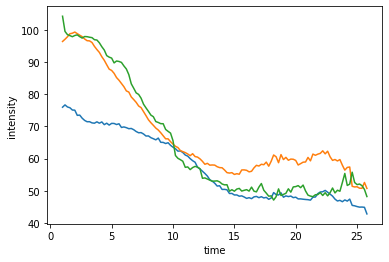

In [12]:
plt.plot(time,intensity)
plt.xlabel("time")
plt.ylabel("intensity");

In [13]:
# Get the predicted TBU probability for each box over the trial
prob_tbu = tbu.get_proba_from_boxes(image_path, model_path, cor_doc, boxes, v=corver)

In [14]:
# For each box, find the intensity when TBU prediction is first true during the trial.
# (Goal: between 45 and 75)
tbu.test_onset_intensity(intensity, prob_tbu, locations)

[59.970542907714844, 63.79784393310547, 73.49423217773438]

In [15]:
# For each box, test how often the true min locations lie close to the fixed min positition.
# (Goal: at least 60%)
tbu.test_location(locations, median_mins)

[0.616, 0.448, 0.728]

In [16]:
# For each box, compute the relative decrease in the intensity from early to late.
# (Goal: at least 25%)
tbu.test_darkening(intensity)

[0.38797636974400557, 0.46275938541127154, 0.47076455948027685]

In [20]:
# Estimate initial FL concentration and film thickness
f0 = f0_fun.f0_estimate(image_path, cor_doc, single_image=True, v=corver)
h0_min = h0_fun.get_h0(image_path, cor_doc, boxes, locations, f0, frame_rate,tile_size=3,sigma=5,box_size=96, v=corver)

In [21]:
f0,h0_min

(0.08667973193615208,
 array([[ 4.76315531,  5.22864082,  6.20677603],
        [42.79535675, 50.72039413, 47.09579849]]))